In [1]:
import math
import random
import os
import time
import json
from functools import partial
from collections import defaultdict

import numpy as np
import pandas as pd

%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf

### Check Version

In [2]:
tf.__version__

'2.9.1'

### GPU Configuration

In [3]:
gpus = tf.config.list_physical_devices('GPU')

2022-11-05 15:37:44.572252: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-05 15:37:44.577954: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-05 15:37:44.578348: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
tf.config.experimental.set_memory_growth(gpus[0], True)

### Pandas Config

In [6]:
pd.set_option('display.max_column', None)

### Input Pipeline

In [7]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

TRAIN_BATCH_SIZE = 4
VAL_BATCH_SIZE = 4

In [8]:
CROP_WIDTH = 227
CROP_HEIGHT = 227

In [9]:
foldFiles = ["adience/unprocessed/fold_0_data.txt",
             "adience/unprocessed/fold_1_data.txt",
             "adience/unprocessed/fold_2_data.txt",
             "adience/unprocessed/fold_3_data.txt",
             "adience/unprocessed/fold_4_data.txt"]

In [10]:
genderMap = defaultdict(lambda : np.NaN)
genderMap['m'] = 0
genderMap['f'] = 1

In [11]:
ages = ['(0, 2)', '(4, 6)', '(8, 13)', '(15, 20)', '(25, 32)', '(38, 43)', '(48, 53)', '(60, 100)']
ageMap = defaultdict(lambda : np.NaN)
for i,a in enumerate(ages):
    ageMap[a] = i

### Dataset Generation

Dataset generation pipeline:
Input: 
- foldFile - Path to fold file. Fold file Describes which images are in the fold and its corresponding labels
- imgBaseFolder - Base folder to search image from
- imgPrefix - Prefix of image file
- genderMap - Map from ['m', 'f', 'u', None], to one hot index
- ageMap - Map from age category to one hot index
- imgWidth - Resulting image width
- imgHeigh - Resulting image height
- batchSize - Int or None, batch size
- configureDs - Function accepting dataset for performance configurations
- preBatch - List of (name, functions) pair that will be mapped before batching. name is used as name parameters for tf graph 
- postBatch - List of (name, functions) that will be mapped after batching. name is used as name parameters for tf graph

The processing functions should have signature function(img, label) -> (img, label)

Pipeline

Read Fold File -> Preprocess filename and labels (dataframe) -> Convert filename and labels to numpy array -> Convert filename and labels to tf dataset -> Parse images and labels -> Configure Dataset for performance -> Pre-Batching preprocessing -> Batch -> Post-Batching preprocessing -> Output

Some preprocessing steps can only be done before and some can only be done after batching, thats why there are seperated pre and post batching list

In [12]:
def generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, batchSize, configureDs=None, preBatch=[], postBatch=[]):
    
    def parseImage(filename):
        img = tf.io.read_file(filename)
        img = tf.image.decode_jpeg(img)
        img = tf.image.resize(img, [imgHeight, imgWidth])
         
        return img
    
    # Read Fold File
    foldData = []
    for f in foldFiles:
        foldData.append(pd.read_csv(f, sep="\t"))
    foldData = pd.concat(foldData)
    
    # Form File Name
    foldData['filename'] = foldData.apply(lambda r: os.path.join(imgBaseFolder, r['user_id'], f"{imgPrefix}.{r['face_id']}.{r['original_image']}"), axis=1)
    
    # Generate Label One Hot Index
    foldData['gender_ind'] = foldData['gender'].map(genderMap)
    foldData['age_ind'] = foldData['age'].map(ageMap)
    
    # Remove dirty data
    foldData.dropna(subset=['gender_ind', 'age_ind'], inplace=True)
    
    # Dataframe to numpy
    filenames = foldData['filename'].to_numpy()
    
    genderIndex = foldData['gender_ind'].to_numpy().astype(int)
    ageIndex = foldData['age_ind'].to_numpy().astype(int)
    
    # Numpy to Dataset
    fnDs = tf.data.Dataset.from_tensor_slices(filenames)
    genderIndDs = tf.data.Dataset.from_tensor_slices(genderIndex)
    ageIndDs = tf.data.Dataset.from_tensor_slices(ageIndex)
    
    # Parse Images
    imageDs = fnDs.map(parseImage, num_parallel_calls=tf.data.AUTOTUNE, name="parse_image")
    
    # Parse Labels
    genderLabDs = genderIndDs.map(lambda x: tf.one_hot(x, genderDepth), num_parallel_calls=tf.data.AUTOTUNE, name="gender_one_hot")
    ageLabDs = ageIndDs.map(lambda x: tf.one_hot(x, ageDepth), num_parallel_calls=tf.data.AUTOTUNE, name="age_one_hot")
    
    # Combine Labels
    labelDs = tf.data.Dataset.zip((genderLabDs, ageLabDs), name="label_zip")
    labelDs = labelDs.map(lambda g,a: {"gender": g, "age": a}, num_parallel_calls=tf.data.AUTOTUNE, name='label_dict')
    
    # Combine Images and Labels into dataset
    ds = tf.data.Dataset.zip((imageDs, labelDs))
    
    # Configure Performance
    if(configureDs is not None):
        ds = configureDs(ds)
    
    # Pre Batch Preprocessing
    for n,f in preBatch:
        ds = ds.map(f, num_parallel_calls=tf.data.AUTOTUNE, name=n)
    
    # Batch
    if(batchSize is not None):
        ds = ds.batch(batchSize, name="ds_batch")
    
    # Post Batch Preprocessing
    for n,f in postBatch:
        ds = ds.map(f, num_parallel_calls=tf.data.AUTOTUNE, name=n)
    
    return ds

### Preprocessings

In [13]:
def trainConfigPerformance(ds):
    #ds = ds.cache()
    ds = ds.shuffle(buffer_size=100)
    ds = ds.repeat()
    return ds

In [14]:
def valConfigPerformance(ds):
    #ds = ds.cache()
    return ds

#### Preprocessing steps

In [15]:
def trainPreprocessA(img, lab):
        
        ud = tf.random.uniform([], dtype=tf.float32)
        udCond = tf.less(ud, 0.5)
        
        img = tf.cond(udCond, lambda: tf.image.flip_up_down(img), lambda: img)
        
        lr = tf.random.uniform([], dtype=tf.float32)
        lrCond = tf.less(lr, 0.5)
        
        img = tf.cond(lrCond, lambda: tf.image.flip_left_right(img), lambda: img)
        
        img = tf.image.random_brightness(img, 63/255)
        
        img = tf.image.random_contrast(img, 0.2, 1.8)
        
        return img, lab

In [16]:
def preprocessB(img, lab, rotL, rotH, shXL, shXH, shYL, shYH, zoomL, zoomH, hTransL, hTransH, vTransL, vTransH):
    shape = tf.shape(img)
    shapeF = tf.cast(shape, tf.float32)

    rRot = tf.random.uniform([shape[0]], minval=rotL, maxval=rotH, dtype=tf.float32)
    rShearX = tf.random.uniform([shape[0]], minval=shXL, maxval=shXH, dtype=tf.float32)
    rShearY = tf.random.uniform([shape[0]], minval=shYL, maxval=shYH, dtype=tf.float32)
    rZoom = tf.random.uniform([shape[0]], minval=zoomL, maxval=zoomH, dtype=tf.float32) #% Zoom
    rTx = tf.random.uniform([shape[0]], minval=hTransL, maxval=hTransH, dtype=tf.float32) #% Horiz Translation
    rTy = tf.random.uniform([shape[0]], minval=vTransL, maxval=vTransH, dtype=tf.float32) #% Vert Translation

    cT = tf.math.cos(rRot)
    sT = tf.math.sin(rRot)

    one = tf.ones([shape[0]], dtype=tf.float32)
    zero = tf.zeros([shape[0]], dtype=tf.float32)

    transC = tf.stack([[1, 0, -shapeF[2]/2], [0, 1, -shapeF[1]/2], [0, 0, 1]])
    transCI = tf.stack([[1, 0, shapeF[2]/2], [0, 1, shapeF[1]/2], [0, 0, 1]])

    trans = tf.transpose(tf.stack([[one, zero, rTx*shapeF[2]], [zero, one, rTy*shapeF[1]], [zero, zero, one]]), [2,0,1])
    rot = tf.transpose(tf.stack([[cT, -sT, zero], [sT, cT, zero], [zero, zero, one]]), [2,0,1])
    scale = tf.transpose(tf.stack([[rZoom, rShearX, zero], [rShearY, rZoom, zero], [zero, zero, one]]), [2,0,1])

    rotScale = rot@scale

    afTMat = transCI @ trans @ rotScale @ transC
    afT = tf.reshape(afTMat, [shape[0], -1])[:,:-1]

    img = tf.raw_ops.ImageProjectiveTransformV3(interpolation='NEAREST', images=img, transforms=afT, output_shape=shape[1:3], fill_value=0)

    return img, lab

In [17]:
def preprocessNoise(img, lab, gMean, gStd, spAmountP, spRatio, speckleVar):
        
    shape = tf.shape(img)
    shapeF = tf.cast(shape, tf.float32)

    # Gaussian Noise
    gNoise = tf.random.normal(shape, gMean, gStd)

    img += gNoise

    # Salt and pepper noise
    spMask = tf.cast(tf.math.less(tf.random.uniform(shape, dtype=tf.float32), spAmountP), tf.float32)
    spNoise = 255*tf.cast(tf.math.less(tf.random.uniform(shape, dtype=tf.float32), spRatio), tf.float32)

    img = tf.math.add(tf.math.multiply(img, 1.0 - spMask), tf.math.multiply(spNoise, spMask))

    # Speckles
    sNoise = speckleVar * tf.random.normal(shape)
    img = img + tf.math.multiply(img, sNoise)

    img = tf.clip_by_value(img, 0, 255)

    return img, lab

In [18]:
def clipValue(img, lab):
    img = tf.clip_by_value(img, 0.0, 255.0)
    return img, lab

In [19]:
def valPreprocessA(img, lab):
        
        img = tf.image.crop_to_bounding_box(img,
                                            (IMG_HEIGHT-CROP_HEIGHT) // 2,
                                            (IMG_WIDTH-CROP_WIDTH) // 2,
                                            CROP_HEIGHT,
                                            CROP_WIDTH)
        
        return img, lab

#### Label extractor 

In [20]:
def prepareLabel(img, lab):
    
    lab = lab['gender']
    
    return img, {"recon" : img, "gender" : lab }

### Generate Folds for K-Folds validation

In [21]:
def generateFoldDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, trainBatchSize, valBatchSize, trainConfigureDs=None, trainPreBatch=[], trainPostBatch=[], valConfigureDs=None, valPreBatch=[], valPostBatch=[]):
    '''
        Returns list of (train, validation) datasets
    '''
    
    N = len(foldFiles)
    
    folds = []
    
    for i in range(N):
        
        trainFiles = foldFiles[:i]
        if(i < N-1):
            trainFiles.extend(foldFiles[i+1:])
            
        valFiles = foldFiles[i]
        
        trainDs = generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, trainBatchSize, configureDs=trainConfigureDs, preBatch=trainPreBatch, postBatch=trainPostBatch)
        valDs = generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, valBatchSize, configureDs=valConfigureDs, preBatch=valPreBatch, postBatch=valPostBatch)
        
        folds.append((trainDs, valDs))
        
    return folds

In [22]:
genParams = {
            "rotation": [-math.pi, math.pi],
            "shearX": [-0.2, 0.2],
            "shearY": [-0.2, 0.2],
            
            "zoom": [0.8, 1.2], # +- 20%
            "hTranslation": [-0.2, 0.2], # +- 20%
            "vTranslation": [-0.2, 0.2], # +- 20%
            
            "gaussianMean": 0.0,
            "gaussianStd": 2.0,
            
            "spAmount": 0.0001,
            "spRatio": 0.5,
            
            "speckleVar": 0.01
        }

In [23]:
trainPreprocessB = partial(preprocessB,
                           rotL = genParams['rotation'][0],
                           rotH = genParams['rotation'][1],
                           shXL = genParams['shearX'][0],
                           shXH = genParams['shearX'][1], 
                           shYL = genParams['shearY'][0],
                           shYH = genParams['shearY'][1],
                           zoomL = genParams['zoom'][0],
                           zoomH = genParams['zoom'][1],
                           hTransL = genParams['hTranslation'][0],
                           hTransH = genParams['hTranslation'][1],
                           vTransL = genParams['vTranslation'][0],
                           vTransH = genParams['vTranslation'][1])

In [24]:
trainPreprocessC = partial(preprocessNoise,
                           gMean = genParams['gaussianMean'],
                           gStd = genParams['gaussianStd'],
                           spAmountP = genParams['spAmount'],
                           spRatio = genParams['spRatio'],
                           speckleVar = genParams['speckleVar'])

In [25]:
trainPreBatch = [("train_process_a", trainPreprocessA)]
trainPostBatch = [("train_process_b", trainPreprocessB),
                  ("train_process_c", trainPreprocessC),
                  ("train_clip", clipValue),
                  ("train_prepare_label", prepareLabel)]

valPreBatch = [("val_prepare_label", prepareLabel)]

In [26]:
folds = generateFoldDs(foldFiles, "adience/faces", "coarse_tilt_aligned_face", genderMap, ageMap, 2, 8, 
                       IMG_WIDTH, IMG_HEIGHT, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE, 
                       trainConfigureDs=trainConfigPerformance, trainPreBatch=trainPreBatch, 
                       trainPostBatch=trainPostBatch,
                       valConfigureDs=valConfigPerformance, valPreBatch=valPreBatch)

2022-11-05 15:37:44.857904: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-05 15:37:44.858633: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-05 15:37:44.858996: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-05 15:37:44.859399: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [27]:
len(folds)

5

### Check data

In [28]:
for x,y in folds[0][0].take(1):
    pass

In [29]:
x

<tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
array([[[[0.00000000e+00, 1.32298380e-01, 1.07302296e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [4.07838202e+00, 3.34453058e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[1.22015190e+00, 1.77226865e+00, 7.82010436e-01],
         [2.66833663e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 7.68502593e-01, 0.00000000e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 5.74665070e-01],
         [0.00000000e+00, 2.87845224e-01, 1.24589550e+00],
         [0.00000000e+00, 3.40628058e-01, 2.22689867e+00]],

        [[1.01226103e+00, 2.48239064e+00, 0.00000000e+00],
         [9.56931710e-01, 8.21961880e-01, 1.02781050e-01],
         [2.25362420e+00, 2.18281221e+00, 0.00000000e+00],
         ...,
         [1

In [30]:
y

{'recon': <tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
 array([[[[0.00000000e+00, 1.32298380e-01, 1.07302296e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          ...,
          [4.07838202e+00, 3.34453058e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],
 
         [[1.22015190e+00, 1.77226865e+00, 7.82010436e-01],
          [2.66833663e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 7.68502593e-01, 0.00000000e+00],
          ...,
          [0.00000000e+00, 0.00000000e+00, 5.74665070e-01],
          [0.00000000e+00, 2.87845224e-01, 1.24589550e+00],
          [0.00000000e+00, 3.40628058e-01, 2.22689867e+00]],
 
         [[1.01226103e+00, 2.48239064e+00, 0.00000000e+00],
          [9.56931710e-01, 8.21961880e-01, 1.02781050e-01],
          [2.25362420e+00, 2.18281221e+00, 0.00000000e+0

<IPython.core.display.Javascript object>


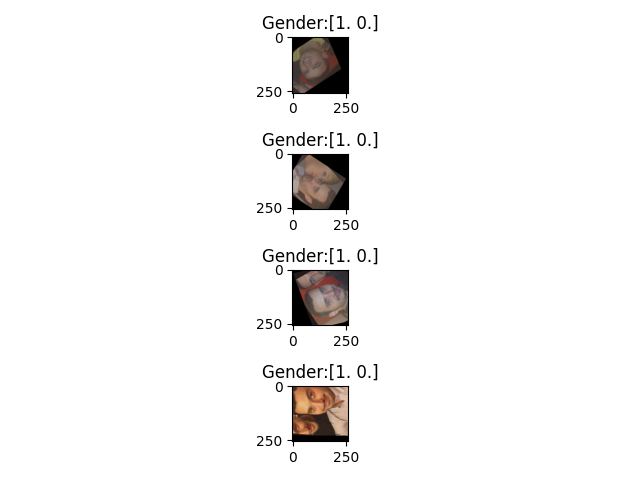

In [31]:
fig1, ax1 = plt.subplots(nrows=TRAIN_BATCH_SIZE, ncols=1)

if(TRAIN_BATCH_SIZE is None or TRAIN_BATCH_SIZE == 1):
    ax1.imshow(x/255)
    ax1.set_title(y)
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax1[i].imshow(x[i]/255)
        ax1[i].set_title(f"Gender:{y['gender'][i]}")
        
plt.tight_layout()

### Model

In [32]:
def createModel(latentSize):
    inp = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    encoder = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, 7, strides=(4,4), padding='same', activation='relu', name='enc_conv1'),
        tf.keras.layers.Conv2D(128, 5, strides=(2,2), padding='same', activation='relu', name='enc_conv2'),
        tf.keras.layers.Conv2D(256, 3, strides=(2,2), padding='same', activation='relu', name='enc_conv3'),
        tf.keras.layers.Conv2D(128, 3, strides=(2,2), padding='same', activation='relu', name='enc_conv4'),
        tf.keras.layers.Conv2D(64, 1, padding='same', activation='relu', name='enc_conv5'),
        tf.keras.layers.Flatten(name="enc_flat"),
        tf.keras.layers.Dense(latentSize, name="enc_out")
    ], name='enc')
    
    decoder = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(latentSize), name='dec_inp'),
        tf.keras.layers.Dense(8*8*64, activation='relu', name='dec_fc1'),
        tf.keras.layers.Reshape(target_shape=(8,8,64), name='dec_reshape'),
        tf.keras.layers.Conv2DTranspose(128, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv1'),
        tf.keras.layers.Conv2DTranspose(256, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv2'),
        tf.keras.layers.Conv2DTranspose(128, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv3'),
        tf.keras.layers.Conv2DTranspose(64, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv4'),
        tf.keras.layers.Conv2DTranspose(3, 3, strides=(2,2), padding='same', activation='tanh', name='dec_deconv5')
    ], name='dec')

    fc1 = tf.keras.layers.Dense(256, activation='relu', name='fc1')
    do1 = tf.keras.layers.Dropout(0.5, name='do1')

    fc2 = tf.keras.layers.Dense(2, activation='softmax', name='gender_out')
    
    # Preprocess Input
    preInp = inp / 127.5 - 1.0
    
    latent = encoder(preInp)
    recon = decoder(latent)
    recon = tf.math.multiply((recon + 1.0), 127.5, name='recon')
    
    o = fc1(latent)
    o = do1(o)
    
    outLab = fc2(o)
    
    model = tf.keras.models.Model(inputs=inp, outputs={"recon": recon, "gender": outLab}, name='AE_15')
    
    #encoder.summary()
    #decoder.summary()
    
    return model

In [33]:
LATENT_SIZE = 128

In [34]:
model = createModel(LATENT_SIZE)

In [35]:
model.summary()

Model: "AE_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 256, 256, 3)  0           ['tf.math.truediv[0][0]']        
                                                                                                  
 enc (Sequential)               (None, 128)          1337280     ['tf.math.subtract[0][0]']   

### Compile Model

In [36]:
STEPS_PER_EPOCH = 1000
EPOCH = 600

START_EPOCH = 0
END_EPOCH = START_EPOCH + EPOCH

#### Learning Rate Schedule

In [37]:
def schedule(epoch, lr):
    return lr

In [38]:
logBasePath = "log/AE_15"
logPrefix = "log"

In [39]:
for i, (train, val) in enumerate([folds[0]]):
    
    model = createModel(LATENT_SIZE)
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    loss = {"gender": tf.keras.losses.CategoricalCrossentropy(), "recon": tf.keras.losses.MeanSquaredError()}
    lossWeight = {"gender": 2500, "recon": 1}
    metrics = {"gender": 'accuracy'}
    
    model.compile(optimizer=opt, loss=loss, loss_weights=lossWeight, metrics=metrics)
    
    tboardCb = tf.keras.callbacks.TensorBoard(log_dir=f"{logBasePath}/{logPrefix}_{i}", histogram_freq=1, profile_batch=(2,10))
    lrSchedule = tf.keras.callbacks.LearningRateScheduler(schedule)
    
    cbs = [tboardCb]
    
    model.evaluate(val)
    model.fit(train, initial_epoch=START_EPOCH, epochs=END_EPOCH, steps_per_epoch=STEPS_PER_EPOCH, callbacks=cbs, validation_data=val)

2022-11-05 15:37:48.513574: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-11-05 15:37:48.513592: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2022-11-05 15:37:48.513612: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1665] Profiler found 1 GPUs
2022-11-05 15:37:48.599529: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-11-05 15:37:48.600816: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-11-05 15:37:49.254960: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


  14/3528 [..............................] - ETA: 14s - loss: 7259.6538 - gender_out_loss: 0.6914 - tf.math.multiply_1_loss: 5531.2549 - gender_out_accuracy: 0.5536    

2022-11-05 15:37:50.031748: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3528/3528 [==============================] - 15s 4ms/step - loss: 7729.2988 - gender_out_loss: 0.6955 - tf.math.multiply_1_loss: 5990.5811 - gender_out_accuracy: 0.4721
Epoch 1/600
   1/1000 [..............................] - ETA: 15:47 - loss: 8397.5391 - gender_out_loss: 0.6747 - tf.math.multiply_1_loss: 6710.8232 - gender_out_accuracy: 0.7500

2022-11-05 15:38:04.255705: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-11-05 15:38:04.255785: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.


  10/1000 [..............................] - ETA: 1:08 - loss: 8970.9971 - gender_out_loss: 0.6947 - tf.math.multiply_1_loss: 7234.1392 - gender_out_accuracy: 0.4250

2022-11-05 15:38:04.700831: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-11-05 15:38:04.701705: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-11-05 15:38:04.732965: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:521]  GpuTracer has collected 3098 callback api events and 3057 activity events. 
2022-11-05 15:38:04.758355: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-11-05 15:38:04.788716: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log/AE_15/log_0/plugins/profile/2022_11_05_15_38_04

2022-11-05 15:38:04.829910: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to log/AE_15/log_0/plugins/profile/2022_11_05_15_38_04/rachanon-pc1.trace.json.gz
2022-11-05 15:38:04.867586: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log

1000/1000 [==============================] - 22s 21ms/step - loss: 4399.3198 - gender_out_loss: 0.6757 - tf.math.multiply_1_loss: 2709.9722 - gender_out_accuracy: 0.5888 - val_loss: 3776.0420 - val_gender_out_loss: 0.6827 - val_tf.math.multiply_1_loss: 2069.2461 - val_gender_out_accuracy: 0.5634
Epoch 2/600
1000/1000 [==============================] - 20s 20ms/step - loss: 3150.2659 - gender_out_loss: 0.6549 - tf.math.multiply_1_loss: 1513.0149 - gender_out_accuracy: 0.6165 - val_loss: 3285.7505 - val_gender_out_loss: 0.6815 - val_tf.math.multiply_1_loss: 1581.9065 - val_gender_out_accuracy: 0.5696
Epoch 3/600
1000/1000 [==============================] - 20s 20ms/step - loss: 2910.0898 - gender_out_loss: 0.6482 - tf.math.multiply_1_loss: 1289.5043 - gender_out_accuracy: 0.5993 - val_loss: 3111.8511 - val_gender_out_loss: 0.6835 - val_tf.math.multiply_1_loss: 1402.9731 - val_gender_out_accuracy: 0.5728
Epoch 4/600
1000/1000 [==============================] - 20s 20ms/step - loss: 2854.5

Epoch 28/600
1000/1000 [==============================] - 20s 20ms/step - loss: 2407.3025 - gender_out_loss: 0.6562 - tf.math.multiply_1_loss: 766.8954 - gender_out_accuracy: 0.6062 - val_loss: 2627.5400 - val_gender_out_loss: 0.6775 - val_tf.math.multiply_1_loss: 933.9167 - val_gender_out_accuracy: 0.5682
Epoch 29/600
1000/1000 [==============================] - 20s 20ms/step - loss: 2360.2903 - gender_out_loss: 0.6442 - tf.math.multiply_1_loss: 749.7947 - gender_out_accuracy: 0.6320 - val_loss: 2543.8384 - val_gender_out_loss: 0.6616 - val_tf.math.multiply_1_loss: 889.9550 - val_gender_out_accuracy: 0.5961
Epoch 30/600
1000/1000 [==============================] - 20s 20ms/step - loss: 2353.3035 - gender_out_loss: 0.6360 - tf.math.multiply_1_loss: 763.3800 - gender_out_accuracy: 0.6475 - val_loss: 2724.6531 - val_gender_out_loss: 0.7303 - val_tf.math.multiply_1_loss: 898.8948 - val_gender_out_accuracy: 0.5394
Epoch 31/600
1000/1000 [==============================] - 21s 21ms/step - lo

Epoch 55/600
1000/1000 [==============================] - 20s 20ms/step - loss: 2178.6672 - gender_out_loss: 0.6262 - tf.math.multiply_1_loss: 613.2765 - gender_out_accuracy: 0.6543 - val_loss: 2333.7632 - val_gender_out_loss: 0.6414 - val_tf.math.multiply_1_loss: 730.1677 - val_gender_out_accuracy: 0.6386
Epoch 56/600
1000/1000 [==============================] - 20s 20ms/step - loss: 2120.7161 - gender_out_loss: 0.5988 - tf.math.multiply_1_loss: 623.8162 - gender_out_accuracy: 0.6653 - val_loss: 2359.5867 - val_gender_out_loss: 0.6463 - val_tf.math.multiply_1_loss: 743.8694 - val_gender_out_accuracy: 0.6254
Epoch 57/600
1000/1000 [==============================] - 20s 20ms/step - loss: 2162.1187 - gender_out_loss: 0.6181 - tf.math.multiply_1_loss: 616.9794 - gender_out_accuracy: 0.6547 - val_loss: 2393.7332 - val_gender_out_loss: 0.6581 - val_tf.math.multiply_1_loss: 748.5007 - val_gender_out_accuracy: 0.6094
Epoch 58/600
1000/1000 [==============================] - 20s 20ms/step - lo

Epoch 82/600
1000/1000 [==============================] - 20s 20ms/step - loss: 2102.9775 - gender_out_loss: 0.6009 - tf.math.multiply_1_loss: 600.6727 - gender_out_accuracy: 0.6743 - val_loss: 2239.3276 - val_gender_out_loss: 0.6067 - val_tf.math.multiply_1_loss: 722.6520 - val_gender_out_accuracy: 0.6765
Epoch 83/600
1000/1000 [==============================] - 20s 20ms/step - loss: 2024.7024 - gender_out_loss: 0.5688 - tf.math.multiply_1_loss: 602.6155 - gender_out_accuracy: 0.7048 - val_loss: 2464.5996 - val_gender_out_loss: 0.6945 - val_tf.math.multiply_1_loss: 728.3129 - val_gender_out_accuracy: 0.5689
Epoch 84/600
1000/1000 [==============================] - 20s 20ms/step - loss: 2042.9232 - gender_out_loss: 0.5806 - tf.math.multiply_1_loss: 591.5377 - gender_out_accuracy: 0.6837 - val_loss: 2270.0522 - val_gender_out_loss: 0.6214 - val_tf.math.multiply_1_loss: 716.5882 - val_gender_out_accuracy: 0.6550
Epoch 85/600
1000/1000 [==============================] - 20s 20ms/step - lo

Epoch 109/600
1000/1000 [==============================] - 20s 20ms/step - loss: 1994.9305 - gender_out_loss: 0.5565 - tf.math.multiply_1_loss: 603.5976 - gender_out_accuracy: 0.7130 - val_loss: 2237.3074 - val_gender_out_loss: 0.6133 - val_tf.math.multiply_1_loss: 704.1694 - val_gender_out_accuracy: 0.6609
Epoch 110/600
1000/1000 [==============================] - 20s 20ms/step - loss: 2027.9819 - gender_out_loss: 0.5773 - tf.math.multiply_1_loss: 584.8108 - gender_out_accuracy: 0.7000 - val_loss: 2178.4915 - val_gender_out_loss: 0.5888 - val_tf.math.multiply_1_loss: 706.4590 - val_gender_out_accuracy: 0.6898
Epoch 111/600
1000/1000 [==============================] - 20s 20ms/step - loss: 1943.2927 - gender_out_loss: 0.5389 - tf.math.multiply_1_loss: 595.9407 - gender_out_accuracy: 0.7188 - val_loss: 2490.3777 - val_gender_out_loss: 0.7124 - val_tf.math.multiply_1_loss: 709.3557 - val_gender_out_accuracy: 0.6192
Epoch 112/600
1000/1000 [==============================] - 20s 20ms/step 

1000/1000 [==============================] - 20s 20ms/step - loss: 1964.3938 - gender_out_loss: 0.5555 - tf.math.multiply_1_loss: 575.5796 - gender_out_accuracy: 0.7128 - val_loss: 2134.7483 - val_gender_out_loss: 0.5724 - val_tf.math.multiply_1_loss: 703.7930 - val_gender_out_accuracy: 0.6994
Epoch 136/600
1000/1000 [==============================] - 20s 20ms/step - loss: 1895.2952 - gender_out_loss: 0.5214 - tf.math.multiply_1_loss: 591.7271 - gender_out_accuracy: 0.7440 - val_loss: 2122.4539 - val_gender_out_loss: 0.5686 - val_tf.math.multiply_1_loss: 701.0730 - val_gender_out_accuracy: 0.7065
Epoch 137/600
1000/1000 [==============================] - 20s 20ms/step - loss: 1914.4843 - gender_out_loss: 0.5366 - tf.math.multiply_1_loss: 572.8793 - gender_out_accuracy: 0.7235 - val_loss: 2141.0217 - val_gender_out_loss: 0.5709 - val_tf.math.multiply_1_loss: 713.8566 - val_gender_out_accuracy: 0.7026
Epoch 138/600
1000/1000 [==============================] - 20s 20ms/step - loss: 2002.1

1000/1000 [==============================] - 20s 20ms/step - loss: 1887.2675 - gender_out_loss: 0.5306 - tf.math.multiply_1_loss: 560.6656 - gender_out_accuracy: 0.7285 - val_loss: 2734.7822 - val_gender_out_loss: 0.8154 - val_tf.math.multiply_1_loss: 696.2382 - val_gender_out_accuracy: 0.5969
Epoch 162/600
1000/1000 [==============================] - 20s 20ms/step - loss: 1921.6237 - gender_out_loss: 0.5371 - tf.math.multiply_1_loss: 578.7510 - gender_out_accuracy: 0.7318 - val_loss: 2127.7947 - val_gender_out_loss: 0.5710 - val_tf.math.multiply_1_loss: 700.2562 - val_gender_out_accuracy: 0.6948
Epoch 163/600
1000/1000 [==============================] - 20s 20ms/step - loss: 1873.7511 - gender_out_loss: 0.5257 - tf.math.multiply_1_loss: 559.4601 - gender_out_accuracy: 0.7530 - val_loss: 2061.7981 - val_gender_out_loss: 0.5447 - val_tf.math.multiply_1_loss: 699.9731 - val_gender_out_accuracy: 0.7225
Epoch 164/600
1000/1000 [==============================] - 20s 20ms/step - loss: 1800.5

1000/1000 [==============================] - 20s 20ms/step - loss: 1924.4048 - gender_out_loss: 0.5359 - tf.math.multiply_1_loss: 584.7230 - gender_out_accuracy: 0.7365 - val_loss: 1988.5410 - val_gender_out_loss: 0.5189 - val_tf.math.multiply_1_loss: 691.2848 - val_gender_out_accuracy: 0.7396
Epoch 188/600
1000/1000 [==============================] - 20s 20ms/step - loss: 1759.0964 - gender_out_loss: 0.4796 - tf.math.multiply_1_loss: 560.0744 - gender_out_accuracy: 0.7685 - val_loss: 2182.9260 - val_gender_out_loss: 0.5926 - val_tf.math.multiply_1_loss: 701.4487 - val_gender_out_accuracy: 0.7119
Epoch 189/600
1000/1000 [==============================] - 21s 21ms/step - loss: 1821.4023 - gender_out_loss: 0.5020 - tf.math.multiply_1_loss: 566.3499 - gender_out_accuracy: 0.7535 - val_loss: 1994.9503 - val_gender_out_loss: 0.5236 - val_tf.math.multiply_1_loss: 685.9941 - val_gender_out_accuracy: 0.7413
Epoch 190/600
1000/1000 [==============================] - 20s 20ms/step - loss: 1881.0

1000/1000 [==============================] - 20s 20ms/step - loss: 1706.0798 - gender_out_loss: 0.4615 - tf.math.multiply_1_loss: 552.2552 - gender_out_accuracy: 0.7780 - val_loss: 1954.5077 - val_gender_out_loss: 0.5058 - val_tf.math.multiply_1_loss: 689.9974 - val_gender_out_accuracy: 0.7538
Epoch 214/600
1000/1000 [==============================] - 20s 20ms/step - loss: 1756.0944 - gender_out_loss: 0.4812 - tf.math.multiply_1_loss: 553.0413 - gender_out_accuracy: 0.7552 - val_loss: 2179.3059 - val_gender_out_loss: 0.5901 - val_tf.math.multiply_1_loss: 704.1741 - val_gender_out_accuracy: 0.7042
Epoch 215/600
1000/1000 [==============================] - 20s 20ms/step - loss: 1856.1281 - gender_out_loss: 0.5107 - tf.math.multiply_1_loss: 579.2604 - gender_out_accuracy: 0.7500 - val_loss: 2375.7712 - val_gender_out_loss: 0.6736 - val_tf.math.multiply_1_loss: 691.7904 - val_gender_out_accuracy: 0.6678
Epoch 216/600
1000/1000 [==============================] - 20s 20ms/step - loss: 1740.8

1000/1000 [==============================] - 20s 20ms/step - loss: 1719.7175 - gender_out_loss: 0.4699 - tf.math.multiply_1_loss: 545.0173 - gender_out_accuracy: 0.7765 - val_loss: 1890.7126 - val_gender_out_loss: 0.4852 - val_tf.math.multiply_1_loss: 677.6379 - val_gender_out_accuracy: 0.7659
Epoch 240/600
1000/1000 [==============================] - 20s 20ms/step - loss: 1755.8044 - gender_out_loss: 0.4773 - tf.math.multiply_1_loss: 562.4332 - gender_out_accuracy: 0.7720 - val_loss: 1903.6442 - val_gender_out_loss: 0.4829 - val_tf.math.multiply_1_loss: 696.3965 - val_gender_out_accuracy: 0.7691
Epoch 241/600
1000/1000 [==============================] - 20s 20ms/step - loss: 1676.2275 - gender_out_loss: 0.4533 - tf.math.multiply_1_loss: 542.9332 - gender_out_accuracy: 0.7840 - val_loss: 2320.9089 - val_gender_out_loss: 0.6554 - val_tf.math.multiply_1_loss: 682.3344 - val_gender_out_accuracy: 0.7085
Epoch 242/600
1000/1000 [==============================] - 20s 20ms/step - loss: 1757.4

1000/1000 [==============================] - 20s 20ms/step - loss: 1685.2332 - gender_out_loss: 0.4436 - tf.math.multiply_1_loss: 576.3221 - gender_out_accuracy: 0.7962 - val_loss: 1994.7170 - val_gender_out_loss: 0.5241 - val_tf.math.multiply_1_loss: 684.5787 - val_gender_out_accuracy: 0.7319
Epoch 266/600
1000/1000 [==============================] - 20s 20ms/step - loss: 1579.9404 - gender_out_loss: 0.4216 - tf.math.multiply_1_loss: 525.8668 - gender_out_accuracy: 0.8120 - val_loss: 1935.9178 - val_gender_out_loss: 0.5026 - val_tf.math.multiply_1_loss: 679.3047 - val_gender_out_accuracy: 0.7495
Epoch 267/600
1000/1000 [==============================] - 20s 20ms/step - loss: 1658.7955 - gender_out_loss: 0.4488 - tf.math.multiply_1_loss: 536.6817 - gender_out_accuracy: 0.7803 - val_loss: 1848.2985 - val_gender_out_loss: 0.4684 - val_tf.math.multiply_1_loss: 677.2054 - val_gender_out_accuracy: 0.7766
Epoch 268/600
1000/1000 [==============================] - 20s 20ms/step - loss: 1761.9

1000/1000 [==============================] - 20s 20ms/step - loss: 1577.4819 - gender_out_loss: 0.4068 - tf.math.multiply_1_loss: 560.3668 - gender_out_accuracy: 0.8135 - val_loss: 1981.9514 - val_gender_out_loss: 0.5139 - val_tf.math.multiply_1_loss: 697.1628 - val_gender_out_accuracy: 0.7606
Epoch 292/600
1000/1000 [==============================] - 20s 20ms/step - loss: 1667.3713 - gender_out_loss: 0.4436 - tf.math.multiply_1_loss: 558.4517 - gender_out_accuracy: 0.7915 - val_loss: 1800.0430 - val_gender_out_loss: 0.4444 - val_tf.math.multiply_1_loss: 688.9796 - val_gender_out_accuracy: 0.7938
Epoch 293/600
1000/1000 [==============================] - 20s 20ms/step - loss: 1580.6714 - gender_out_loss: 0.4088 - tf.math.multiply_1_loss: 558.5952 - gender_out_accuracy: 0.8092 - val_loss: 1992.5132 - val_gender_out_loss: 0.5214 - val_tf.math.multiply_1_loss: 688.8940 - val_gender_out_accuracy: 0.7715
Epoch 294/600
1000/1000 [==============================] - 20s 20ms/step - loss: 1608.1

1000/1000 [==============================] - 20s 20ms/step - loss: 1618.0802 - gender_out_loss: 0.4229 - tf.math.multiply_1_loss: 560.9172 - gender_out_accuracy: 0.8043 - val_loss: 1799.8448 - val_gender_out_loss: 0.4466 - val_tf.math.multiply_1_loss: 683.3486 - val_gender_out_accuracy: 0.7852
Epoch 318/600
1000/1000 [==============================] - 20s 20ms/step - loss: 1559.4174 - gender_out_loss: 0.3955 - tf.math.multiply_1_loss: 570.7827 - gender_out_accuracy: 0.8177 - val_loss: 1771.4598 - val_gender_out_loss: 0.4357 - val_tf.math.multiply_1_loss: 682.2930 - val_gender_out_accuracy: 0.7912
Epoch 319/600
1000/1000 [==============================] - 20s 20ms/step - loss: 1534.9564 - gender_out_loss: 0.4031 - tf.math.multiply_1_loss: 527.2237 - gender_out_accuracy: 0.8140 - val_loss: 1711.8140 - val_gender_out_loss: 0.4119 - val_tf.math.multiply_1_loss: 681.9983 - val_gender_out_accuracy: 0.8107
Epoch 320/600
1000/1000 [==============================] - 20s 20ms/step - loss: 1560.8

1000/1000 [==============================] - 20s 20ms/step - loss: 1495.4398 - gender_out_loss: 0.3780 - tf.math.multiply_1_loss: 550.4143 - gender_out_accuracy: 0.8298 - val_loss: 1699.6808 - val_gender_out_loss: 0.4054 - val_tf.math.multiply_1_loss: 686.1132 - val_gender_out_accuracy: 0.8151
Epoch 344/600
1000/1000 [==============================] - 20s 20ms/step - loss: 1492.0543 - gender_out_loss: 0.3744 - tf.math.multiply_1_loss: 555.9978 - gender_out_accuracy: 0.8298 - val_loss: 1759.9093 - val_gender_out_loss: 0.4313 - val_tf.math.multiply_1_loss: 681.5522 - val_gender_out_accuracy: 0.8000
Epoch 345/600
1000/1000 [==============================] - 20s 20ms/step - loss: 1609.0752 - gender_out_loss: 0.4277 - tf.math.multiply_1_loss: 539.7094 - gender_out_accuracy: 0.7975 - val_loss: 2422.6042 - val_gender_out_loss: 0.6930 - val_tf.math.multiply_1_loss: 690.0861 - val_gender_out_accuracy: 0.6593
Epoch 346/600
1000/1000 [==============================] - 20s 20ms/step - loss: 1503.2

1000/1000 [==============================] - 20s 20ms/step - loss: 1552.4460 - gender_out_loss: 0.4034 - tf.math.multiply_1_loss: 544.0559 - gender_out_accuracy: 0.8190 - val_loss: 1679.7446 - val_gender_out_loss: 0.3988 - val_tf.math.multiply_1_loss: 682.7542 - val_gender_out_accuracy: 0.8183
Epoch 370/600
1000/1000 [==============================] - 20s 20ms/step - loss: 1605.2374 - gender_out_loss: 0.4158 - tf.math.multiply_1_loss: 565.7485 - gender_out_accuracy: 0.8040 - val_loss: 1704.7656 - val_gender_out_loss: 0.4103 - val_tf.math.multiply_1_loss: 678.9120 - val_gender_out_accuracy: 0.8165
Epoch 371/600
1000/1000 [==============================] - 20s 20ms/step - loss: 1493.6962 - gender_out_loss: 0.3785 - tf.math.multiply_1_loss: 547.4266 - gender_out_accuracy: 0.8342 - val_loss: 1745.9667 - val_gender_out_loss: 0.4291 - val_tf.math.multiply_1_loss: 673.0963 - val_gender_out_accuracy: 0.7896
Epoch 372/600
1000/1000 [==============================] - 20s 20ms/step - loss: 1528.0

1000/1000 [==============================] - 20s 20ms/step - loss: 1593.2103 - gender_out_loss: 0.4090 - tf.math.multiply_1_loss: 570.6116 - gender_out_accuracy: 0.8090 - val_loss: 1741.1414 - val_gender_out_loss: 0.4283 - val_tf.math.multiply_1_loss: 670.2776 - val_gender_out_accuracy: 0.8041
Epoch 396/600
1000/1000 [==============================] - 20s 20ms/step - loss: 1501.0404 - gender_out_loss: 0.3781 - tf.math.multiply_1_loss: 555.8088 - gender_out_accuracy: 0.8320 - val_loss: 1676.9365 - val_gender_out_loss: 0.4004 - val_tf.math.multiply_1_loss: 675.9432 - val_gender_out_accuracy: 0.8181
Epoch 397/600
1000/1000 [==============================] - 20s 20ms/step - loss: 1433.2003 - gender_out_loss: 0.3545 - tf.math.multiply_1_loss: 546.9875 - gender_out_accuracy: 0.8475 - val_loss: 1646.7725 - val_gender_out_loss: 0.3827 - val_tf.math.multiply_1_loss: 689.9097 - val_gender_out_accuracy: 0.8282
Epoch 398/600
1000/1000 [==============================] - 21s 21ms/step - loss: 1537.6

1000/1000 [==============================] - 21s 21ms/step - loss: 1460.9951 - gender_out_loss: 0.3706 - tf.math.multiply_1_loss: 534.5752 - gender_out_accuracy: 0.8355 - val_loss: 1552.0654 - val_gender_out_loss: 0.3538 - val_tf.math.multiply_1_loss: 667.6398 - val_gender_out_accuracy: 0.8417
Epoch 422/600
1000/1000 [==============================] - 21s 21ms/step - loss: 1462.8733 - gender_out_loss: 0.3699 - tf.math.multiply_1_loss: 538.2241 - gender_out_accuracy: 0.8410 - val_loss: 1627.0814 - val_gender_out_loss: 0.3846 - val_tf.math.multiply_1_loss: 665.4712 - val_gender_out_accuracy: 0.8216
Epoch 423/600
1000/1000 [==============================] - 20s 21ms/step - loss: 1538.8353 - gender_out_loss: 0.3915 - tf.math.multiply_1_loss: 560.0353 - gender_out_accuracy: 0.8205 - val_loss: 1610.3889 - val_gender_out_loss: 0.3764 - val_tf.math.multiply_1_loss: 669.3123 - val_gender_out_accuracy: 0.8302
Epoch 424/600
1000/1000 [==============================] - 20s 20ms/step - loss: 1458.3

1000/1000 [==============================] - 21s 21ms/step - loss: 1378.8068 - gender_out_loss: 0.3382 - tf.math.multiply_1_loss: 533.2958 - gender_out_accuracy: 0.8475 - val_loss: 1699.2054 - val_gender_out_loss: 0.4147 - val_tf.math.multiply_1_loss: 662.4612 - val_gender_out_accuracy: 0.8169
Epoch 448/600
1000/1000 [==============================] - 20s 20ms/step - loss: 1569.7518 - gender_out_loss: 0.4034 - tf.math.multiply_1_loss: 561.2388 - gender_out_accuracy: 0.8170 - val_loss: 1533.6656 - val_gender_out_loss: 0.3494 - val_tf.math.multiply_1_loss: 660.1122 - val_gender_out_accuracy: 0.8461
Epoch 449/600
1000/1000 [==============================] - 20s 20ms/step - loss: 1419.9753 - gender_out_loss: 0.3506 - tf.math.multiply_1_loss: 543.3508 - gender_out_accuracy: 0.8405 - val_loss: 1513.5166 - val_gender_out_loss: 0.3415 - val_tf.math.multiply_1_loss: 659.6812 - val_gender_out_accuracy: 0.8482
Epoch 450/600
1000/1000 [==============================] - 20s 20ms/step - loss: 1401.4

1000/1000 [==============================] - 20s 20ms/step - loss: 1408.0439 - gender_out_loss: 0.3493 - tf.math.multiply_1_loss: 534.6778 - gender_out_accuracy: 0.8518 - val_loss: 1623.7966 - val_gender_out_loss: 0.3816 - val_tf.math.multiply_1_loss: 669.7376 - val_gender_out_accuracy: 0.8260
Epoch 474/600
1000/1000 [==============================] - 20s 20ms/step - loss: 1402.6188 - gender_out_loss: 0.3492 - tf.math.multiply_1_loss: 529.6799 - gender_out_accuracy: 0.8403 - val_loss: 1606.9264 - val_gender_out_loss: 0.3766 - val_tf.math.multiply_1_loss: 665.5249 - val_gender_out_accuracy: 0.8370
Epoch 475/600
1000/1000 [==============================] - 20s 20ms/step - loss: 1395.7670 - gender_out_loss: 0.3497 - tf.math.multiply_1_loss: 521.6060 - gender_out_accuracy: 0.8357 - val_loss: 1578.4225 - val_gender_out_loss: 0.3641 - val_tf.math.multiply_1_loss: 668.2776 - val_gender_out_accuracy: 0.8371
Epoch 476/600
1000/1000 [==============================] - 20s 20ms/step - loss: 1558.5

1000/1000 [==============================] - 20s 20ms/step - loss: 1400.7866 - gender_out_loss: 0.3467 - tf.math.multiply_1_loss: 534.1122 - gender_out_accuracy: 0.8528 - val_loss: 1676.1057 - val_gender_out_loss: 0.4043 - val_tf.math.multiply_1_loss: 665.4652 - val_gender_out_accuracy: 0.8177
Epoch 500/600
1000/1000 [==============================] - 20s 20ms/step - loss: 1366.7773 - gender_out_loss: 0.3377 - tf.math.multiply_1_loss: 522.5208 - gender_out_accuracy: 0.8495 - val_loss: 1604.5562 - val_gender_out_loss: 0.3754 - val_tf.math.multiply_1_loss: 666.0999 - val_gender_out_accuracy: 0.8378
Epoch 501/600
1000/1000 [==============================] - 21s 21ms/step - loss: 1493.0555 - gender_out_loss: 0.3758 - tf.math.multiply_1_loss: 553.6210 - gender_out_accuracy: 0.8338 - val_loss: 1531.9542 - val_gender_out_loss: 0.3467 - val_tf.math.multiply_1_loss: 665.2151 - val_gender_out_accuracy: 0.8454
Epoch 502/600
1000/1000 [==============================] - 20s 20ms/step - loss: 1323.4

1000/1000 [==============================] - 20s 20ms/step - loss: 1471.3875 - gender_out_loss: 0.3757 - tf.math.multiply_1_loss: 532.1567 - gender_out_accuracy: 0.8310 - val_loss: 1579.9829 - val_gender_out_loss: 0.3679 - val_tf.math.multiply_1_loss: 660.3454 - val_gender_out_accuracy: 0.8350
Epoch 526/600
1000/1000 [==============================] - 20s 20ms/step - loss: 1366.9746 - gender_out_loss: 0.3312 - tf.math.multiply_1_loss: 538.9266 - gender_out_accuracy: 0.8465 - val_loss: 1896.4211 - val_gender_out_loss: 0.4962 - val_tf.math.multiply_1_loss: 655.9943 - val_gender_out_accuracy: 0.7749
Epoch 527/600
1000/1000 [==============================] - 20s 20ms/step - loss: 1346.8259 - gender_out_loss: 0.3332 - tf.math.multiply_1_loss: 513.9440 - gender_out_accuracy: 0.8558 - val_loss: 1515.8723 - val_gender_out_loss: 0.3423 - val_tf.math.multiply_1_loss: 660.1470 - val_gender_out_accuracy: 0.8443
Epoch 528/600
1000/1000 [==============================] - 20s 20ms/step - loss: 1387.7

1000/1000 [==============================] - 20s 20ms/step - loss: 1327.8868 - gender_out_loss: 0.3182 - tf.math.multiply_1_loss: 532.3427 - gender_out_accuracy: 0.8665 - val_loss: 1496.2513 - val_gender_out_loss: 0.3349 - val_tf.math.multiply_1_loss: 658.9701 - val_gender_out_accuracy: 0.8530
Epoch 552/600
1000/1000 [==============================] - 20s 20ms/step - loss: 1334.7548 - gender_out_loss: 0.3188 - tf.math.multiply_1_loss: 537.7344 - gender_out_accuracy: 0.8587 - val_loss: 1561.4869 - val_gender_out_loss: 0.3598 - val_tf.math.multiply_1_loss: 661.9677 - val_gender_out_accuracy: 0.8486
Epoch 553/600
1000/1000 [==============================] - 20s 20ms/step - loss: 1352.9380 - gender_out_loss: 0.3307 - tf.math.multiply_1_loss: 526.0928 - gender_out_accuracy: 0.8547 - val_loss: 1453.3207 - val_gender_out_loss: 0.3187 - val_tf.math.multiply_1_loss: 656.4469 - val_gender_out_accuracy: 0.8584
Epoch 554/600
1000/1000 [==============================] - 20s 20ms/step - loss: 1386.9

1000/1000 [==============================] - 20s 20ms/step - loss: 1294.8320 - gender_out_loss: 0.3044 - tf.math.multiply_1_loss: 533.8160 - gender_out_accuracy: 0.8683 - val_loss: 1707.7936 - val_gender_out_loss: 0.4197 - val_tf.math.multiply_1_loss: 658.6193 - val_gender_out_accuracy: 0.8016
Epoch 578/600
1000/1000 [==============================] - 20s 20ms/step - loss: 1408.0908 - gender_out_loss: 0.3529 - tf.math.multiply_1_loss: 525.9415 - gender_out_accuracy: 0.8447 - val_loss: 1638.6335 - val_gender_out_loss: 0.3923 - val_tf.math.multiply_1_loss: 657.9296 - val_gender_out_accuracy: 0.8238
Epoch 579/600
1000/1000 [==============================] - 20s 20ms/step - loss: 1356.3184 - gender_out_loss: 0.3278 - tf.math.multiply_1_loss: 536.8431 - gender_out_accuracy: 0.8553 - val_loss: 1714.7067 - val_gender_out_loss: 0.4242 - val_tf.math.multiply_1_loss: 654.1909 - val_gender_out_accuracy: 0.7992
Epoch 580/600
1000/1000 [==============================] - 20s 20ms/step - loss: 1312.2

In [40]:
out = model(x)

In [41]:
out

{'recon': <tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
 array([[[[2.21427035e+00, 1.91920865e+00, 1.89976883e+00],
          [9.01638389e-01, 6.88310266e-01, 9.24999595e-01],
          [7.88738847e-01, 5.85366189e-01, 8.05427551e-01],
          ...,
          [4.92666364e-01, 3.30285877e-01, 4.33678329e-01],
          [4.83060479e-01, 2.94651389e-01, 4.60656881e-01],
          [6.40554428e-01, 4.62602377e-01, 6.94625497e-01]],
 
         [[1.01519918e+00, 7.23374784e-01, 5.59656739e-01],
          [1.14399695e+00, 5.66792786e-01, 8.09949338e-01],
          [6.14039421e-01, 3.97679061e-01, 5.51563203e-01],
          ...,
          [3.35149616e-01, 1.50137544e-01, 2.15159655e-01],
          [2.94165015e-01, 1.57957524e-01, 2.27721781e-01],
          [3.21971923e-01, 1.95674300e-01, 3.94221246e-01]],
 
         [[6.74463809e-01, 4.28867787e-01, 5.57513714e-01],
          [6.13119900e-01, 3.31433415e-01, 6.19192004e-01],
          [4.50146645e-01, 2.25168318e-01, 4.34567481e-0

<IPython.core.display.Javascript object>


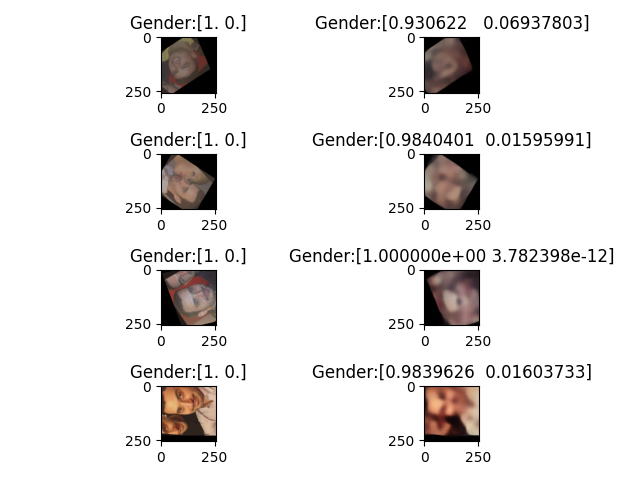

In [42]:
fig2, ax2 = plt.subplots(nrows=TRAIN_BATCH_SIZE, ncols=2)

if(TRAIN_BATCH_SIZE is None or TRAIN_BATCH_SIZE == 1):
    ax2[0].imshow(x/255)
    ax2[0].set_title(y['gender'])
    
    ax2[1].imshow(out['recon']/255)
    ax2[1].set_title(out['gender'])
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax2[i, 0].imshow(x[i]/255)
        ax2[i, 0].set_title(f"Gender:{y['gender'][i]}")
        
        ax2[i, 1].imshow(out['recon'][i]/255)
        ax2[i, 1].set_title(f"Gender:{out['gender'][i]}")
        
plt.tight_layout()

In [43]:
for xTest, yTest in folds[0][1].take(1):
    pass

In [44]:
outTest = model(xTest)

In [45]:
outTest

{'recon': <tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
 array([[[[1.94490290e+00, 1.49321342e+00, 1.31785285e+00],
          [7.58606493e-01, 4.88364995e-01, 5.26796103e-01],
          [7.04717755e-01, 4.11441922e-01, 4.92096394e-01],
          ...,
          [1.94747150e-01, 1.28387511e-01, 1.99306905e-01],
          [2.32213140e-01, 1.40896440e-01, 2.51371711e-01],
          [3.72509211e-01, 2.55255103e-01, 4.28168625e-01]],
 
         [[8.77190530e-01, 4.96222973e-01, 3.31015438e-01],
          [9.25037563e-01, 3.37307900e-01, 3.85519713e-01],
          [6.36473417e-01, 3.04378867e-01, 3.90155464e-01],
          ...,
          [1.51262283e-01, 6.77123666e-02, 1.14525855e-01],
          [1.54203326e-01, 8.28203559e-02, 1.37066245e-01],
          [2.00834423e-01, 1.18143260e-01, 2.77765095e-01]],
 
         [[6.38844490e-01, 3.29457521e-01, 3.68694216e-01],
          [5.18474579e-01, 2.49525011e-01, 3.80435586e-01],
          [4.70711142e-01, 2.22052485e-01, 3.76772583e-0

<IPython.core.display.Javascript object>


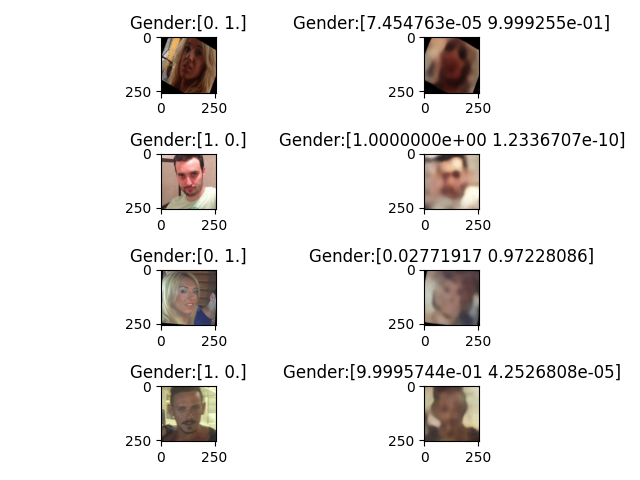

In [46]:
fig3, ax3 = plt.subplots(nrows=VAL_BATCH_SIZE, ncols=2)

if(VAL_BATCH_SIZE is None or VAL_BATCH_SIZE == 1):
    ax3[0].imshow(x/255)
    ax3[0].set_title(yTest['gender'])
    
    ax3[1].imshow(out['recon']/255)
    ax3[1].set_title(outTest['gender'])
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax3[i, 0].imshow(xTest[i]/255)
        ax3[i, 0].set_title(f"Gender:{yTest['gender'][i]}")
        
        ax3[i, 1].imshow(outTest['recon'][i]/255)
        ax3[i, 1].set_title(f"Gender:{outTest['gender'][i]}")
        
plt.tight_layout()